### TalkingData AdTracking Fraud Detection Challenge

TalkingData is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, click fraud is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping approx. 70% of the active mobile devices in China, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released the problem on Kaggle (https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection)

#### Understanding the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0).

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Data
# specify column dtypes to save memory (by default pandas reads some columns as floats)
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

train_sample = pd.read_csv('train_sample.csv',dtype = dtypes, usecols = colnames)

In [3]:
# data size
train_sample.shape

(100000, 7)

In [4]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


### Exploring the Data 
#### Univariate Analysis

In [5]:
# number of observations and missing values
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null uint16
app              100000 non-null uint16
device           100000 non-null uint16
os               100000 non-null uint16
channel          100000 non-null uint16
click_time       100000 non-null object
is_attributed    100000 non-null uint8
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


We can see there are no missing values in the data.

In [6]:
# Number of unique values in each variable

for var in train_sample.columns:
    print(var,':', len(train_sample[var].unique()))

ip : 28470
app : 161
device : 100
os : 130
channel : 161
click_time : 80350
is_attributed : 2


In [7]:
# Data types
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

Besides, click_time all the variables are int type,but they are actually categorical.

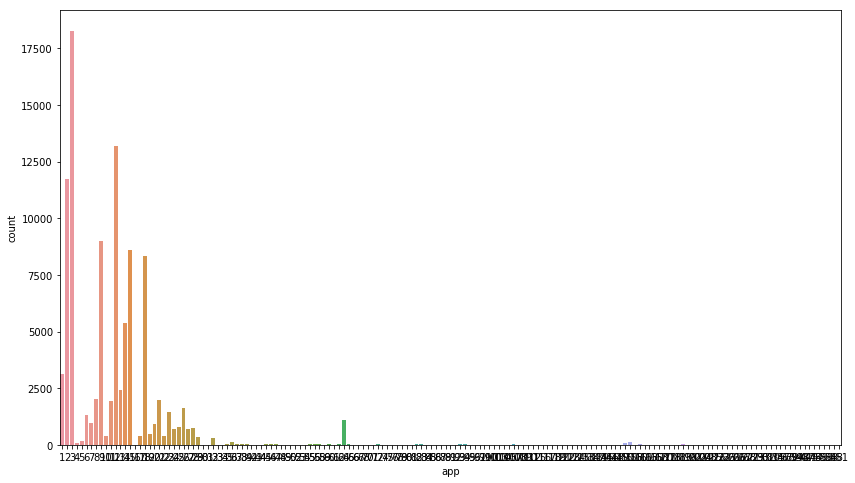

In [8]:
# Distribution of app
plt.figure(figsize = (14,8))
sns.countplot(x = 'app', data = train_sample)

The distribution of app looks very skewed, where most of the app have are very rare and few of the app represent very high number of observations in the data.

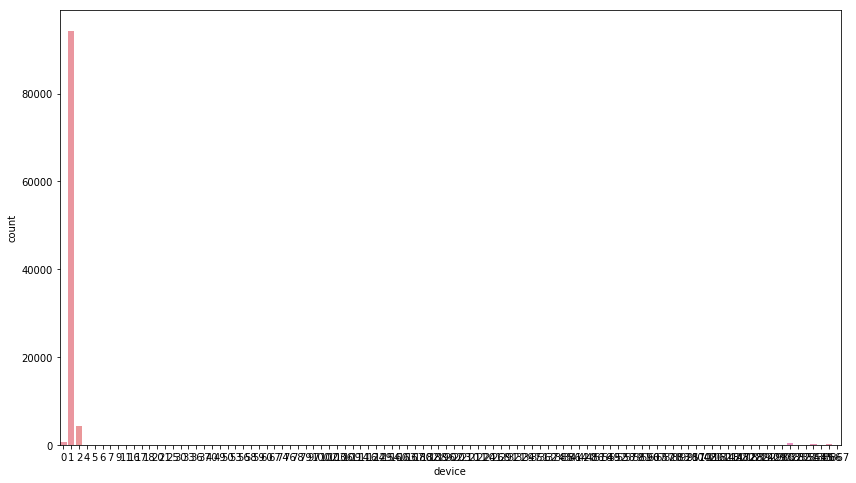

In [9]:
# Distribution of device
plt.figure(figsize = (14,8))
sns.countplot(x = 'device', data = train_sample)

This looks very highly skewed, only very few of the device represents the maximum observations in the data.

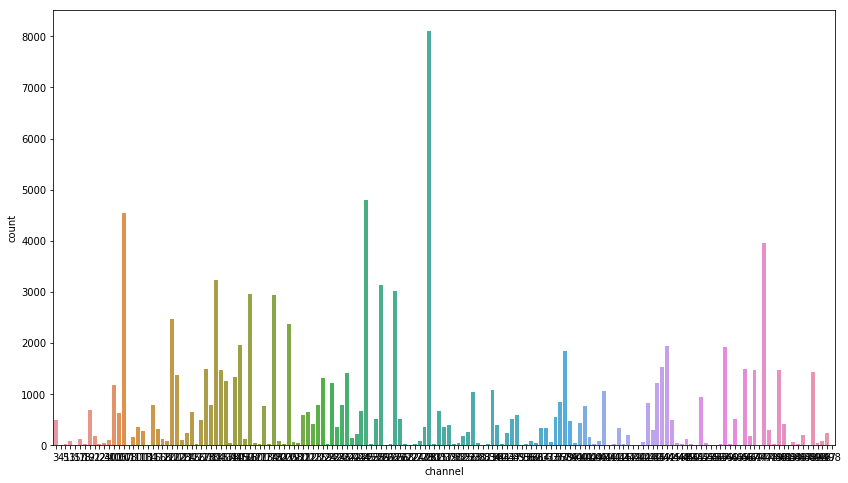

In [10]:
# channel
plt.figure(figsize = (14,8))
sns.countplot(x = 'channel', data = train_sample)

Channel has fairly uniform distribution.

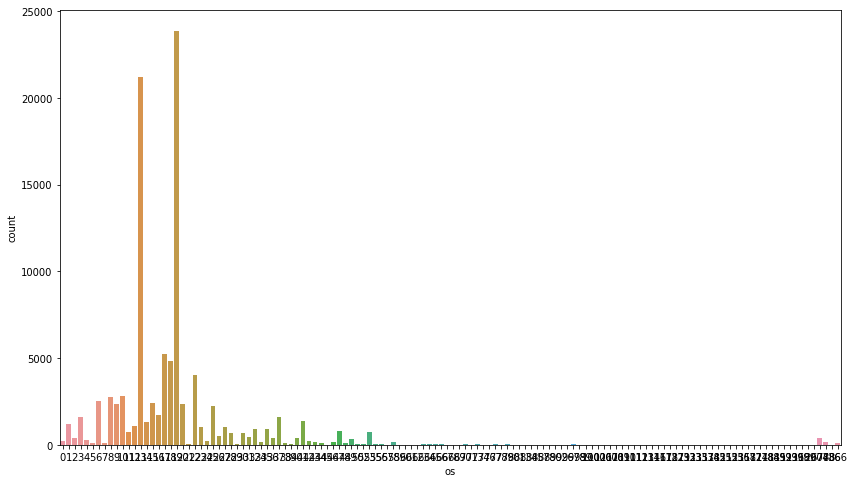

In [11]:
# OS
plt.figure(figsize = (14,8))
sns.countplot(x = 'os', data = train_sample)

In [12]:
# Distribution of the target variable 
train_sample['is_attributed'].value_counts(normalize = True) * 100

0    99.773
1     0.227
Name: is_attributed, dtype: float64

The target is also highly imbalanced, where above 99.7% of the data are fraudluent and only about 0.23% of them are genuine clicks that download the apps.

### Segmented Univariate Analysis

In [13]:
# relation of target with app
app_target = train_sample.groupby('app')['is_attributed'].agg(['mean','count'])

# taking only the most frequent apps for plotting (top 80%)
frequent_apps = app_target[app_target['count'] > app_target['count'].quantile(0.80)]
frequent_apps.reset_index(inplace = True)

# add the target labels
frequent_apps = frequent_apps.merge(train_sample, on = 'app', how = 'inner')
frequent_apps.head()


,app,mean,count,ip,device,os,channel,click_time,is_attributed
0,1,0.0,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,0.0,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,0.0,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,0.0,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,0.0,3135,34067,1,15,134,2017-11-07 15:06:06,0


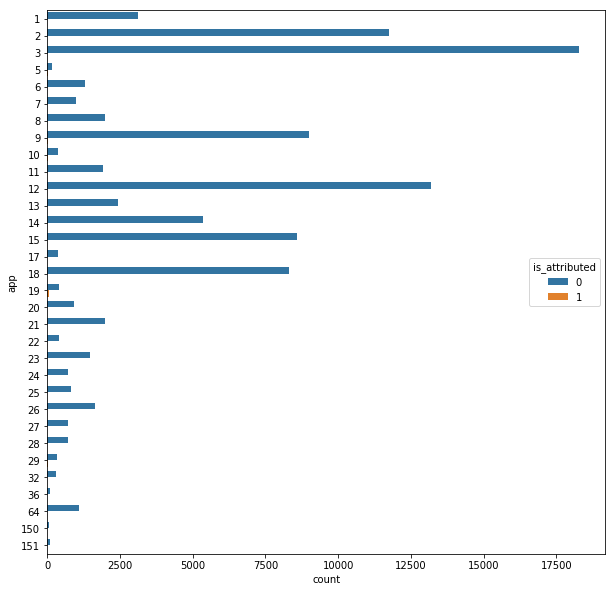

In [14]:
plt.figure(figsize = (10,10))
sns.countplot(y = 'app', hue = 'is_attributed', data = frequent_apps)

In [15]:
# relation of device with target
device_count = train_sample.groupby('device').size().reset_index(name= "count")

# taking only frequent devices
frequent_devices = device_count[device_count['count'] > device_count['count'].quantile(0.80)]
frequent_devices

,device,count
0,0,541
1,1,94338
2,2,4345
3,4,3
4,5,7
5,6,8
9,16,7
13,21,3
14,25,3
16,33,3


In [16]:
frequent_devices = frequent_devices.merge(train_sample[['device','is_attributed']], on = 'device', how = 'inner')
frequent_devices.head()

,device,count,is_attributed
0,0,541,1
1,0,541,0
2,0,541,0
3,0,541,0
4,0,541,0


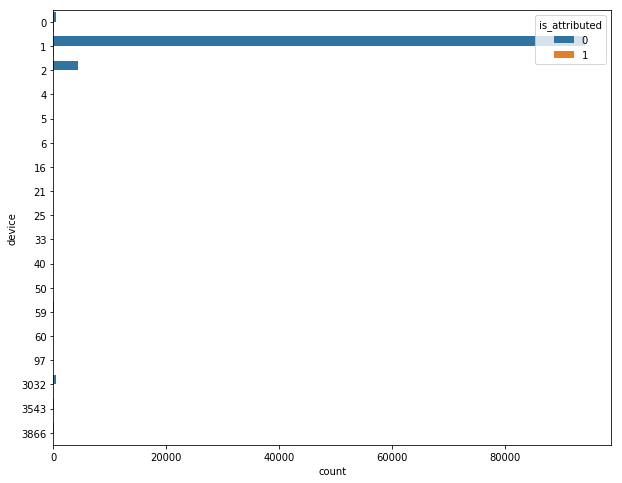

In [17]:
plt.figure(figsize = (10,8))
sns.countplot(y = 'device', hue = 'is_attributed', data = frequent_devices)

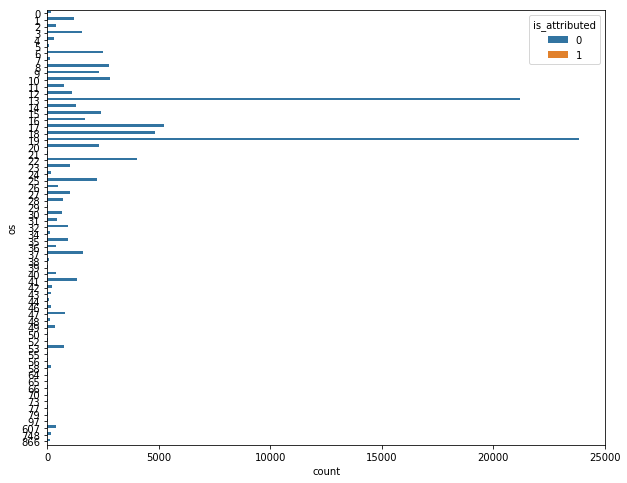

In [18]:
# relation between os and target
os_count = train_sample.groupby('os').size().reset_index(name = 'count')

# taking frequent os
frequent_os = os_count[os_count['count'] > os_count['count'].quantile(0.50)]
frequent_os = frequent_os.merge(train_sample, on = 'os', how = 'inner')

plt.figure(figsize = (10,8))
sns.countplot(y = 'os', hue = 'is_attributed', data = frequent_os)

### Feature Enginnering

Derive more features from the clik_time.

In [19]:
# creating datetime variables
def get_timefeatures(df):
    # derive new features using the click_time column
    df["click_time"] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['click_time'].dt.dayofweek
    df['day_of_year'] = df['click_time'].dt.dayofyear
    df['month'] = df['click_time'].dt.month
    df['hour'] = df['click_time'].dt.hour
    return df

In [20]:
# create the features
train_sample = get_timefeatures(train_sample)

# drop the original variable
train_sample.drop('click_time', axis = 1, inplace = True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [21]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

The new variables created are in int types and for less memory we will convert them to lower dtype.

In [22]:
int_vars = ['day_of_week','day_of_year','month','hour']
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

In [23]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

### IP Grouping Based Features
Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

In [24]:
# number of clicks by count of IP address
# note that we are explicitly asking pandas to re-encode the aggregated features 
# as 'int16' to save memory
ip_count = train_sample.groupby('ip').size().reset_index(name = 'ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


We can now merge this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc.

In [25]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [26]:
# create the new features
train_sample = grouped_features(train_sample)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [27]:
# garbage collect (unused) object
gc.collect()

2070

### Modeling

Let's now build models to predict the variable is_attributed (downloaded). We'll try the several variants of boosting (adaboost, gradient boosting and XGBoost), tune the hyperparameters in each model and choose the one which gives the best performance.

In [28]:
# training and test splits

# separate predictors and target
X = train_sample.drop('is_attributed', axis = 1)
y = train_sample[['is_attributed']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [29]:
# check the average download rates in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


### AdaBoost

In [30]:
# adaboost classifier with max 600 decision trees of depth=2
# learning_rate/shrinkage=1.5

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with tree estimator
adaboost_model_1 = AdaBoostClassifier(base_estimator=tree,
                                      n_estimators = 600,
                                      learning_rate = 1.5,
                                      algorithm = "SAMME")

In [31]:
# fit the model
adaboost_model_1.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.5, n_estimators=600, random_state=None)

In [32]:
# predictions in test data
pred_test = adaboost_model_1.predict_proba(X_test)
pred_test[:10]

array([[0.5259697 , 0.4740303 ],
       [0.52720083, 0.47279917],
       [0.533081  , 0.466919  ],
       [0.52194781, 0.47805219],
       [0.51032691, 0.48967309],
       [0.52721323, 0.47278677],
       [0.5183883 , 0.4816117 ],
       [0.52170927, 0.47829073],
       [0.52412251, 0.47587749],
       [0.51552875, 0.48447125]])

In [33]:
# auc score
metrics.roc_auc_score(y_test,pred_test[:,1])

0.928385534118433

#### AdaBoost Hyperparameter Tuning

In [34]:
# tune the max depth of the base estimatore(tree) and the n_estimators(number of trees)
param_grid = {'base_estimator__max_depth':[2,5],
             'n_estimators':[200,400,600]}

In [35]:
# base estimator
tree = DecisionTreeClassifier()

# adaboost
ABC = AdaBoostClassifier(base_estimator=tree, 
                        learning_rate = 0.6,
                        algorithm = 'SAMME')

# perform grid search
grid_search_ABC = GridSearchCV(estimator=ABC, 
                               cv=3,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               return_train_score = True, 
                               verbose = 1,
                               n_jobs = -1)

In [36]:
# fit the grid search
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'base_estimator__max_depth': [2, 5], 'n_estimators': [200, 400, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [37]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,15.580008,0.290096,0.439490,0.013874,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,6.111043e-04
1,31.094520,0.198232,0.852057,0.022370,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,6.179779e-04
2,47.377646,0.559885,1.237360,0.015286,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,2.530744e-04
3,35.392361,0.594573,0.533905,0.001881,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.902385,0.943840,0.937692,0.927972,0.018267,4,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,70.419366,0.671295,1.021271,0.004312,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.892638,0.938943,0.945042,0.925541,0.023399,5,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,86.621374,8.392965,1.020950,0.175773,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.882550,0.925758,0.937828,0.915378,0.023731,6,1.000000,1.000000,1.000000,1.000000,6.409876e-17


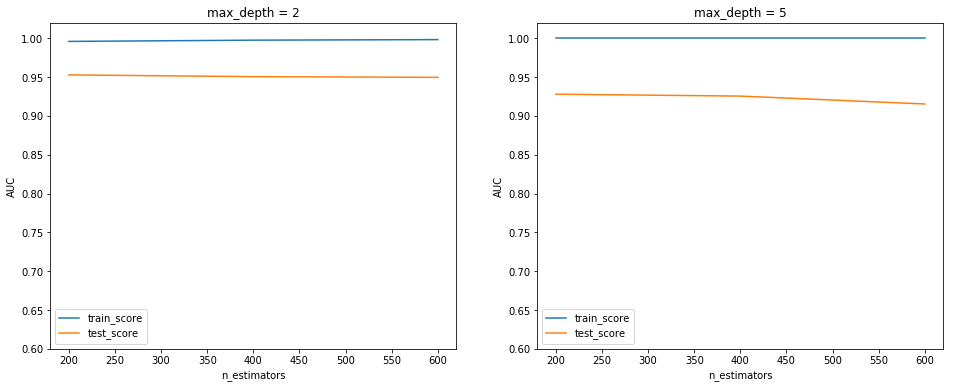

In [38]:
# plotting AUC with hyperparameter combinations
plt.figure(figsize = (16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    #subplot 1(of n)
    plt.subplot(1,2,n+1)
    depth_cv = cv_results[cv_results['param_base_estimator__max_depth'] == depth]
    plt.plot(depth_cv['param_n_estimators'], depth_cv['mean_train_score'])
    plt.plot(depth_cv['param_n_estimators'], depth_cv['mean_test_score'])
    plt.xlabel("n_estimators")
    plt.ylabel("AUC")
    plt.title("max_depth = {}".format(depth))
    plt.ylim([0.60,1.02])
    plt.legend(['train_score','test_score'], loc = 'lower left')

The results above show that:

- The ensemble with max_depth=5 is clearly overfitting (training auc is almost 1, while the test score is much lower)
- At max_depth=2, the model performs slightly better (approx 95% AUC) with a higher test score
Thus, we should go ahead with max_depth=2 and n_estimators=200.

In [39]:
#predictions
pred_test = grid_search_ABC.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,pred_test)

0.9478933155154654

We see a improvement in the auc score. The score can be further improved by tuning the learning rate.

### Gradient Boosting 

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - learning_rate (shrinkage) and subsample.

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between learning_rate and n_estimators - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting subsample to less than 1), we can have the individual models built on random subsamples of size subsample. That way, each tree will be trained on different subsets and reduce the model's variance.



In [40]:
# parameter grid
param_grid = {'learning_rate':[0.2, 0.6, 0.9],
             "subsample":[0.3, 0.6, 0.9]}

# base estimator
GBC = GradientBoostingClassifier()


In [41]:
# grid search
grid_search_GBC = GridSearchCV(estimator=GBC,
                               cv=3,
                               param_grid = param_grid,
                               scoring = 'roc_auc',
                               return_train_score = True,
                               verbose = 1,
                               n_jobs = -1)

grid_search_GBC.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   55.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.2, 0.6, 0.9], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [42]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.564777,0.081068,0.067487,0.004770,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.837080,0.631676,0.531350,0.666704,0.127247,3,0.860104,0.722648,0.644796,0.742516,0.089014
1,8.685441,0.243570,0.064162,0.003291,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.778422,0.572780,0.534780,0.628662,0.107028,4,0.795845,0.707240,0.667791,0.723626,0.053546
2,8.844680,0.276199,0.061171,0.001693,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.871311,0.689015,0.643046,0.734459,0.098573,1,0.960454,0.649842,0.722555,0.777617,0.132649
3,6.651547,0.150202,0.061172,0.002488,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.692653,0.533612,0.622388,0.616218,0.065075,5,0.845665,0.621279,0.689583,0.718842,0.093912
4,8.420816,0.116189,0.060839,0.000814,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.643529,0.412614,0.691240,0.582460,0.121669,7,0.617593,0.346391,0.740025,0.568003,0.164482
5,8.897874,0.353645,0.061171,0.001246,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.758840,0.271098,0.610542,0.546826,0.204154,8,0.740584,0.285591,0.637502,0.554559,0.194789
6,6.774549,0.132210,0.060505,0.003083,0.9,0.3,"{'learning_rate': 0.9, 'subsample': 0.3}",0.438364,0.369174,0.633127,0.480220,0.111748,9,0.485707,0.384268,0.553399,0.474458,0.069504
7,8.349010,0.101941,0.062168,0.000469,0.9,0.6,"{'learning_rate': 0.9, 'subsample': 0.6}",0.609151,0.568634,0.602827,0.593537,0.017798,6,0.678241,0.666673,0.617576,0.654163,0.026299
8,6.883590,0.604844,0.035241,0.007116,0.9,0.9,"{'learning_rate': 0.9, 'subsample': 0.9}",0.817049,0.558564,0.718262,0.697958,0.106499,2,0.814931,0.639228,0.658069,0.704076,0.078763


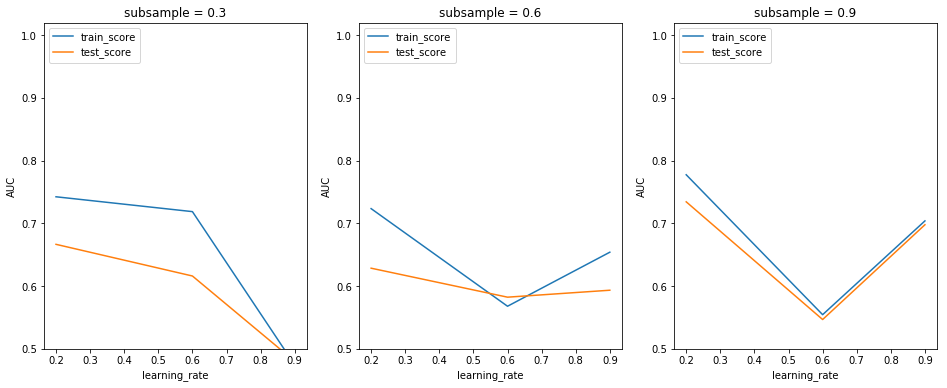

In [43]:
# plotting AUC with hyperparameter combinations
plt.figure(figsize = (16,6))
for n, subsample in enumerate(param_grid['subsample']):
    #subplot 1(of n)
    plt.subplot(1,3,n+1)
    depth_cv = cv_results[cv_results['param_subsample'] == subsample]
    plt.plot(depth_cv['param_learning_rate'], depth_cv['mean_train_score'])
    plt.plot(depth_cv['param_learning_rate'], depth_cv['mean_test_score'])
    plt.xlabel("learning_rate")
    plt.ylabel("AUC")
    plt.title("subsample = {}".format(subsample))
    plt.ylim([0.50,1.02])
    plt.legend(['train_score','test_score'], loc = 'upper left')

In [44]:
# predictions
pred_test = grid_search_GBC.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,pred_test)

0.6156702580806813

### XGBoost

In [45]:
# XGboost with default parameters
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [46]:
# predictions on test data
pred_test = xgb.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,pred_test)

0.9484868732425735

In [47]:
# hper parameter tuning
param_grid = {'learning_rate': [0.01, 0.1, 0.3], 
             'subsample': [0.5, 0.6, 0.8]}

xgb = XGBClassifier()

grid_search_xgb = GridSearchCV(estimator=xgb,
                              param_grid = param_grid,
                              cv = 3,
                              scoring = 'roc_auc',
                              return_train_score = True,
                              verbose = 1,
                              n_jobs = -1)

grid_search_xgb.fit(X_train,y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   59.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 0.3], 'subsample': [0.5, 0.6, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [48]:
cv_results = pd.DataFrame(grid_search_xgb.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,8.254259,0.105083,0.084773,0.008579,0.01,0.5,"{'learning_rate': 0.01, 'subsample': 0.5}",0.860382,0.868645,0.865508,0.864845,0.003406,7,0.868145,0.864564,0.865356,0.866022,0.001536
1,8.389564,0.053417,0.081783,0.007463,0.01,0.6,"{'learning_rate': 0.01, 'subsample': 0.6}",0.860320,0.868362,0.864828,0.864503,0.003291,8,0.867977,0.864572,0.865354,0.865968,0.001456
2,8.266893,0.016945,0.083443,0.004099,0.01,0.8,"{'learning_rate': 0.01, 'subsample': 0.8}",0.859497,0.867964,0.865265,0.864242,0.003532,9,0.867287,0.864239,0.865048,0.865525,0.001289
3,8.402198,0.036962,0.109375,0.005543,0.1,0.5,"{'learning_rate': 0.1, 'subsample': 0.5}",0.935715,0.977266,0.951272,0.954751,0.017141,4,0.984410,0.973000,0.985115,0.980841,0.005552
4,8.589030,0.021591,0.106716,0.007768,0.1,0.6,"{'learning_rate': 0.1, 'subsample': 0.6}",0.941120,0.976630,0.951425,0.956392,0.014916,2,0.984799,0.976549,0.985967,0.982438,0.004191
5,8.344353,0.037222,0.103391,0.006582,0.1,0.8,"{'learning_rate': 0.1, 'subsample': 0.8}",0.945330,0.973600,0.949189,0.956040,0.012516,3,0.985410,0.975483,0.985371,0.982088,0.004670
6,8.419153,0.026591,0.121676,0.002443,0.3,0.5,"{'learning_rate': 0.3, 'subsample': 0.5}",0.924395,0.964082,0.946322,0.944933,0.016232,5,0.998053,0.997025,0.997433,0.997504,0.000423
7,8.574404,0.048123,0.125666,0.006359,0.3,0.6,"{'learning_rate': 0.3, 'subsample': 0.6}",0.913850,0.962910,0.948425,0.941728,0.020581,6,0.998432,0.998053,0.997983,0.998156,0.000197
8,6.818445,0.331155,0.090109,0.007313,0.3,0.8,"{'learning_rate': 0.3, 'subsample': 0.8}",0.932536,0.977115,0.963043,0.957565,0.018607,1,0.998730,0.997157,0.998653,0.998180,0.000724


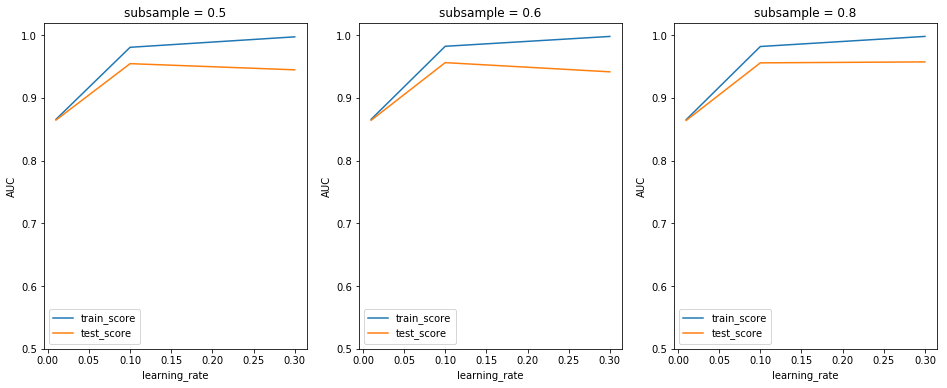

In [49]:
# plotting AUC with hyperparameter combinations
plt.figure(figsize = (16,6))
for n, subsample in enumerate(param_grid['subsample']):
    #subplot 1(of n)
    plt.subplot(1,3,n+1)
    depth_cv = cv_results[cv_results['param_subsample'] == subsample]
    plt.plot(depth_cv['param_learning_rate'], depth_cv['mean_train_score'])
    plt.plot(depth_cv['param_learning_rate'], depth_cv['mean_test_score'])
    plt.xlabel("learning_rate")
    plt.ylabel("AUC")
    plt.title("subsample = {}".format(subsample))
    plt.ylim([0.50,1.02])
    plt.legend(['train_score','test_score'], loc = 'lower left')

In [50]:
# final predictions
pred_test = grid_search_xgb.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,pred_test)

0.9544586430579916

With Xgboost we got the best auc score of 0.955. So, xgboost performed the best. There is still more of hyper parameter tuning that can be performed with xgboost to check for the improvement.

### Feature importance

In [51]:
feature_importance = dict(zip(X_train.columns,grid_search_xgb.best_estimator_.feature_importances_))
feature_importance                        

{'app': 0.1769121,
 'channel': 0.17314586,
 'day_of_week': 0.050643012,
 'day_of_year': 0.0,
 'device': 0.15689774,
 'hour': 0.054290082,
 'ip': 0.055890437,
 'ip_count': 0.09737105,
 'ip_day_hour': 0.04446315,
 'ip_hour_app': 0.027687624,
 'ip_hour_channel': 0.0,
 'ip_hour_device': 0.04535119,
 'ip_hour_os': 0.035611317,
 'month': 0.0,
 'os': 0.081736505}

In [52]:
feature_importance = grid_search_xgb.best_estimator_.feature_importances_
feature_importance = pd.DataFrame(feature_importance, columns= ['importance'])
feature_importance['variables'] = X_train.columns

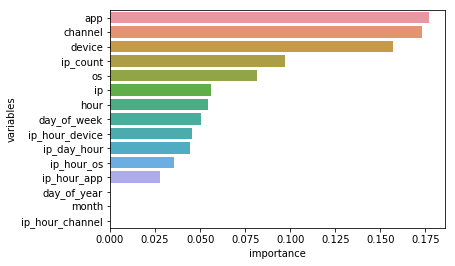

In [53]:
feature_importance.sort_values(by = 'importance', ascending=False, inplace = True)
sns.barplot(y = 'variables', x = 'importance', data = feature_importance)